In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import skimage
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration, run

Populating the interactive namespace from numpy and matplotlib


In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y

In [3]:
def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))
        
def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [4]:
def features_extractor(tile, params, extractor, threshold):
    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    extracted = []
    if _std < min_std:
        extracted.append([0] * 1981)
    else:
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for k in range(origin.shape[1]):
            x, y = CDF(origin[:,k])
            ten = [y[np.argmin(np.absolute(x-threshold[k][j]))] for j in range(99)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]])
    return extracted

In [5]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [6]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

In [7]:
yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD585/'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
features_fn = 'CSHL_grid_features/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)
features_fn = features_fn+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)

savepath = 'CSHL_scoremaps_new/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

paired_structures = ['5N', '6N', '7N', '7nn', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures
window_size = 224

/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [8]:
%%time
section = 200
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape
extractor = patch_extractor(params)

ALREADY DOWNLOADED FILE
CPU times: user 865 ms, sys: 931 ms, total: 1.8 s
Wall time: 2.67 s


In [9]:
%%time
stride = int(30/0.46)
polygons = [(contour['name'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(section).iterrows()]
xs, ys = np.meshgrid(np.arange(0, n, stride), np.arange(0, m, stride), indexing='xy')
locations = np.c_[xs.flat, ys.flat]
valid_structure = {}
for contour_id, contour in polygons:
    valid_structure[contour_id] = contour

CPU times: user 5.22 ms, sys: 3.99 ms, total: 9.2 ms
Wall time: 17.1 ms


In [10]:
valid_structure.keys()

dict_keys(['SC', 'Pn', 'Sp5C', 'IO', 'Tz', 'VTA', 'RtTg', '7n', 'RMC', 'IC'])

In [60]:
15400*(112/65)**2

45722.508875739644

In [58]:
len(locations)

45315

In [11]:
len(grid_features)

NameError: name 'grid_features' is not defined

In [ ]:
%%time
grid_features = {}
for i in range(len(locations)):
    print(i, len(locations))
    left = locations[i][0]
    right = int(min(left + window_size, n))
    up = locations[i][1]
    down = int(min(up + window_size, m))
    tile = img[up:down, left:right]
    grid_index = str(section)+'_'+str(left)+'_'+str(up)
    try:
        extracted = features_extractor(tile, params, extractor, thresholds)
        grid_features[grid_index] = extracted
    except:
        continue

0 45315
1 45315
2 45315
3 45315
4 45315
5 45315
6 45315
7 45315
8 45315
9 45315
10 45315
11 45315
12 45315
13 45315
14 45315
15 45315
16 45315
17 45315
18 45315
19 45315
20 45315
21 45315
22 45315
23 45315
24 45315
25 45315
26 45315
27 45315
28 45315
29 45315
30 45315
31 45315
32 45315
33 45315
34 45315
35 45315
36 45315
37 45315
38 45315
39 45315
40 45315
41 45315
42 45315
43 45315
44 45315
45 45315
46 45315
47 45315
48 45315
49 45315
50 45315
51 45315
52 45315
53 45315
54 45315
55 45315
56 45315
57 45315
58 45315
59 45315
60 45315
61 45315
62 45315
63 45315
64 45315
65 45315
66 45315
67 45315
68 45315
69 45315
70 45315
71 45315
72 45315
73 45315
74 45315
75 45315
76 45315
77 45315
78 45315
79 45315
80 45315
81 45315
82 45315
83 45315
84 45315
85 45315
86 45315
87 45315
88 45315
89 45315
90 45315
91 45315
92 45315
93 45315
94 45315
95 45315
96 45315
97 45315
98 45315
99 45315
100 45315
101 45315
102 45315
103 45315
104 45315
105 45315
106 45315
107 45315
108 45315
109 45315
110 45315


831 45315
832 45315
833 45315
834 45315
835 45315
836 45315
837 45315
838 45315
839 45315
840 45315
841 45315
842 45315
843 45315
844 45315
845 45315
846 45315
847 45315
848 45315
849 45315
850 45315
851 45315
852 45315
853 45315
854 45315
855 45315
856 45315
857 45315
858 45315
859 45315
860 45315
861 45315
862 45315
863 45315
864 45315
865 45315
866 45315
867 45315
868 45315
869 45315
870 45315
871 45315
872 45315
873 45315
874 45315
875 45315
876 45315
877 45315
878 45315
879 45315
880 45315
881 45315
882 45315
883 45315
884 45315
885 45315
886 45315
887 45315
888 45315
889 45315
890 45315
891 45315
892 45315
893 45315
894 45315
895 45315
896 45315
897 45315
898 45315
899 45315
900 45315
901 45315
902 45315
903 45315
904 45315
905 45315
906 45315
907 45315
908 45315
909 45315
910 45315
911 45315
912 45315
913 45315
914 45315
915 45315
916 45315
917 45315
918 45315
919 45315
920 45315
921 45315
922 45315
923 45315
924 45315
925 45315
926 45315
927 45315
928 45315
929 45315
930 45315


1592 45315
1593 45315
1594 45315
1595 45315
1596 45315
1597 45315
1598 45315
1599 45315
1600 45315
1601 45315
1602 45315
1603 45315
1604 45315
1605 45315
1606 45315
1607 45315
1608 45315
1609 45315
1610 45315
1611 45315
1612 45315
1613 45315
1614 45315
1615 45315
1616 45315
1617 45315
1618 45315
1619 45315
1620 45315
1621 45315
1622 45315
1623 45315
1624 45315
1625 45315
1626 45315
1627 45315
1628 45315
1629 45315
1630 45315
1631 45315
1632 45315
1633 45315
1634 45315
1635 45315
1636 45315
1637 45315
1638 45315
1639 45315
1640 45315
1641 45315
1642 45315
1643 45315
1644 45315
1645 45315
1646 45315
1647 45315
1648 45315
1649 45315
1650 45315
1651 45315
1652 45315
1653 45315
1654 45315
1655 45315
1656 45315
1657 45315
1658 45315
1659 45315
1660 45315
1661 45315
1662 45315
1663 45315
1664 45315
1665 45315
1666 45315
1667 45315
1668 45315
1669 45315
1670 45315
1671 45315
1672 45315
1673 45315
1674 45315
1675 45315
1676 45315
1677 45315
1678 45315
1679 45315
1680 45315
1681 45315
1682 45315

2386 45315
2387 45315
2388 45315
2389 45315
2390 45315
2391 45315
2392 45315
2393 45315
2394 45315
2395 45315
2396 45315
2397 45315
2398 45315
2399 45315
2400 45315
2401 45315
2402 45315
2403 45315
2404 45315
2405 45315
2406 45315
2407 45315
2408 45315
2409 45315
2410 45315
2411 45315
2412 45315
2413 45315
2414 45315
2415 45315
2416 45315
2417 45315
2418 45315
2419 45315
2420 45315
2421 45315
2422 45315
2423 45315
2424 45315
2425 45315
2426 45315
2427 45315
2428 45315
2429 45315
2430 45315
2431 45315
2432 45315
2433 45315
2434 45315
2435 45315
2436 45315
2437 45315
2438 45315
2439 45315
2440 45315
2441 45315
2442 45315
2443 45315
2444 45315
2445 45315
2446 45315
2447 45315
2448 45315
2449 45315
2450 45315
2451 45315
2452 45315
2453 45315
2454 45315
2455 45315
2456 45315
2457 45315
2458 45315
2459 45315
2460 45315
2461 45315
2462 45315
2463 45315
2464 45315
2465 45315
2466 45315
2467 45315
2468 45315
2469 45315
2470 45315
2471 45315
2472 45315
2473 45315
2474 45315
2475 45315
2476 45315

3181 45315
3182 45315
3183 45315
3184 45315
3185 45315
3186 45315
3187 45315
3188 45315
3189 45315
3190 45315
3191 45315
3192 45315
3193 45315
3194 45315
3195 45315
3196 45315
3197 45315
3198 45315
3199 45315
3200 45315
3201 45315
3202 45315
3203 45315
3204 45315
3205 45315
3206 45315
3207 45315
3208 45315
3209 45315
3210 45315
3211 45315
3212 45315
3213 45315
3214 45315
3215 45315
3216 45315
3217 45315
3218 45315
3219 45315
3220 45315
3221 45315
3222 45315
3223 45315
3224 45315
3225 45315
3226 45315
3227 45315
3228 45315
3229 45315
3230 45315
3231 45315
3232 45315
3233 45315
3234 45315
3235 45315
3236 45315
3237 45315
3238 45315
3239 45315
3240 45315
3241 45315
3242 45315
3243 45315
3244 45315
3245 45315
3246 45315
3247 45315
3248 45315
3249 45315
3250 45315
3251 45315
3252 45315
3253 45315
3254 45315
3255 45315
3256 45315
3257 45315
3258 45315
3259 45315
3260 45315
3261 45315
3262 45315
3263 45315
3264 45315
3265 45315
3266 45315
3267 45315
3268 45315
3269 45315
3270 45315
3271 45315

3976 45315
3977 45315
3978 45315
3979 45315
3980 45315
3981 45315
3982 45315
3983 45315
3984 45315
3985 45315
3986 45315
3987 45315
3988 45315
3989 45315
3990 45315
3991 45315
3992 45315
3993 45315
3994 45315
3995 45315
3996 45315
3997 45315
3998 45315
3999 45315
4000 45315
4001 45315
4002 45315
4003 45315
4004 45315
4005 45315
4006 45315
4007 45315
4008 45315
4009 45315
4010 45315
4011 45315
4012 45315
4013 45315
4014 45315
4015 45315
4016 45315
4017 45315
4018 45315
4019 45315
4020 45315
4021 45315
4022 45315
4023 45315
4024 45315
4025 45315
4026 45315
4027 45315
4028 45315
4029 45315
4030 45315
4031 45315
4032 45315
4033 45315
4034 45315
4035 45315
4036 45315
4037 45315
4038 45315
4039 45315
4040 45315
4041 45315
4042 45315
4043 45315
4044 45315
4045 45315
4046 45315
4047 45315
4048 45315
4049 45315
4050 45315
4051 45315
4052 45315
4053 45315
4054 45315
4055 45315
4056 45315
4057 45315
4058 45315
4059 45315
4060 45315
4061 45315
4062 45315
4063 45315
4064 45315
4065 45315
4066 45315

4771 45315
4772 45315
4773 45315
4774 45315
4775 45315
4776 45315
4777 45315
4778 45315
4779 45315
4780 45315
4781 45315
4782 45315
4783 45315
4784 45315
4785 45315
4786 45315
4787 45315
4788 45315
4789 45315
4790 45315
4791 45315
4792 45315
4793 45315
4794 45315
4795 45315
4796 45315
4797 45315
4798 45315
4799 45315
4800 45315
4801 45315
4802 45315
4803 45315
4804 45315
4805 45315
4806 45315
4807 45315
4808 45315
4809 45315
4810 45315
4811 45315
4812 45315
4813 45315
4814 45315
4815 45315
4816 45315
4817 45315
4818 45315
4819 45315
4820 45315
4821 45315
4822 45315
4823 45315
4824 45315
4825 45315
4826 45315
4827 45315
4828 45315
4829 45315
4830 45315
4831 45315
4832 45315
4833 45315
4834 45315
4835 45315
4836 45315
4837 45315
4838 45315
4839 45315
4840 45315
4841 45315
4842 45315
4843 45315
4844 45315
4845 45315
4846 45315
4847 45315
4848 45315
4849 45315
4850 45315
4851 45315
4852 45315
4853 45315
4854 45315
4855 45315
4856 45315
4857 45315
4858 45315
4859 45315
4860 45315
4861 45315

5566 45315
5567 45315
5568 45315
5569 45315
5570 45315
5571 45315
5572 45315
5573 45315
5574 45315
5575 45315
5576 45315
5577 45315
5578 45315
5579 45315
5580 45315
5581 45315
5582 45315
5583 45315
5584 45315
5585 45315
5586 45315
5587 45315
5588 45315
5589 45315
5590 45315
5591 45315
5592 45315
5593 45315
5594 45315
5595 45315
5596 45315
5597 45315
5598 45315
5599 45315
5600 45315
5601 45315
5602 45315
5603 45315
5604 45315
5605 45315
5606 45315
5607 45315
5608 45315
5609 45315
5610 45315
5611 45315
5612 45315
5613 45315
5614 45315
5615 45315
5616 45315
5617 45315
5618 45315
5619 45315
5620 45315
5621 45315
5622 45315
5623 45315
5624 45315
5625 45315
5626 45315
5627 45315
5628 45315
5629 45315
5630 45315
5631 45315
5632 45315
5633 45315
5634 45315
5635 45315
5636 45315
5637 45315
5638 45315
5639 45315
5640 45315
5641 45315
5642 45315
5643 45315
5644 45315
5645 45315
5646 45315
5647 45315
5648 45315
5649 45315
5650 45315
5651 45315
5652 45315
5653 45315
5654 45315
5655 45315
5656 45315

6361 45315
6362 45315
6363 45315
6364 45315
6365 45315
6366 45315
6367 45315
6368 45315
6369 45315
6370 45315
6371 45315
6372 45315
6373 45315
6374 45315
6375 45315
6376 45315
6377 45315
6378 45315
6379 45315
6380 45315
6381 45315
6382 45315
6383 45315
6384 45315
6385 45315
6386 45315
6387 45315
6388 45315
6389 45315
6390 45315
6391 45315
6392 45315
6393 45315
6394 45315
6395 45315
6396 45315
6397 45315
6398 45315
6399 45315
6400 45315
6401 45315
6402 45315
6403 45315
6404 45315
6405 45315
6406 45315
6407 45315
6408 45315
6409 45315
6410 45315
6411 45315
6412 45315
6413 45315
6414 45315
6415 45315
6416 45315
6417 45315
6418 45315
6419 45315
6420 45315
6421 45315
6422 45315
6423 45315
6424 45315
6425 45315
6426 45315
6427 45315
6428 45315
6429 45315
6430 45315
6431 45315
6432 45315
6433 45315
6434 45315
6435 45315
6436 45315
6437 45315
6438 45315
6439 45315
6440 45315
6441 45315
6442 45315
6443 45315
6444 45315
6445 45315
6446 45315
6447 45315
6448 45315
6449 45315
6450 45315
6451 45315

7156 45315
7157 45315
7158 45315
7159 45315
7160 45315
7161 45315
7162 45315
7163 45315
7164 45315
7165 45315
7166 45315
7167 45315
7168 45315
7169 45315
7170 45315
7171 45315
7172 45315
7173 45315
7174 45315
7175 45315
7176 45315
7177 45315
7178 45315
7179 45315
7180 45315
7181 45315
7182 45315
7183 45315
7184 45315
7185 45315
7186 45315
7187 45315
7188 45315
7189 45315
7190 45315
7191 45315
7192 45315
7193 45315
7194 45315
7195 45315
7196 45315
7197 45315
7198 45315
7199 45315
7200 45315
7201 45315
7202 45315
7203 45315
7204 45315
7205 45315
7206 45315
7207 45315
7208 45315
7209 45315
7210 45315
7211 45315
7212 45315
7213 45315
7214 45315
7215 45315
7216 45315
7217 45315
7218 45315
7219 45315
7220 45315
7221 45315
7222 45315
7223 45315
7224 45315
7225 45315
7226 45315
7227 45315
7228 45315
7229 45315
7230 45315
7231 45315
7232 45315
7233 45315
7234 45315
7235 45315
7236 45315
7237 45315
7238 45315
7239 45315
7240 45315
7241 45315
7242 45315
7243 45315
7244 45315
7245 45315
7246 45315

7951 45315
7952 45315
7953 45315
7954 45315
7955 45315
7956 45315
7957 45315
7958 45315
7959 45315
7960 45315
7961 45315
7962 45315
7963 45315
7964 45315
7965 45315
7966 45315
7967 45315
7968 45315
7969 45315
7970 45315
7971 45315
7972 45315
7973 45315
7974 45315
7975 45315
7976 45315
7977 45315
7978 45315
7979 45315
7980 45315
7981 45315
7982 45315
7983 45315
7984 45315
7985 45315
7986 45315
7987 45315
7988 45315
7989 45315
7990 45315
7991 45315
7992 45315
7993 45315
7994 45315
7995 45315
7996 45315
7997 45315
7998 45315
7999 45315
8000 45315
8001 45315
8002 45315
8003 45315
8004 45315
8005 45315
8006 45315
8007 45315
8008 45315
8009 45315
8010 45315
8011 45315
8012 45315
8013 45315
8014 45315
8015 45315
8016 45315
8017 45315
8018 45315
8019 45315
8020 45315
8021 45315
8022 45315
8023 45315
8024 45315
8025 45315
8026 45315
8027 45315
8028 45315
8029 45315
8030 45315
8031 45315
8032 45315
8033 45315
8034 45315
8035 45315
8036 45315
8037 45315
8038 45315
8039 45315
8040 45315
8041 45315

8746 45315
8747 45315
8748 45315
8749 45315
8750 45315
8751 45315
8752 45315
8753 45315
8754 45315
8755 45315
8756 45315
8757 45315
8758 45315
8759 45315
8760 45315
8761 45315
8762 45315
8763 45315
8764 45315
8765 45315
8766 45315
8767 45315
8768 45315
8769 45315
8770 45315
8771 45315
8772 45315
8773 45315
8774 45315
8775 45315
8776 45315
8777 45315
8778 45315
8779 45315
8780 45315
8781 45315
8782 45315
8783 45315
8784 45315
8785 45315
8786 45315
8787 45315
8788 45315
8789 45315
8790 45315
8791 45315
8792 45315
8793 45315
8794 45315
8795 45315
8796 45315
8797 45315
8798 45315
8799 45315
8800 45315
8801 45315
8802 45315
8803 45315
8804 45315
8805 45315
8806 45315
8807 45315
8808 45315
8809 45315
8810 45315
8811 45315
8812 45315
8813 45315
8814 45315
8815 45315
8816 45315
8817 45315
8818 45315
8819 45315
8820 45315
8821 45315
8822 45315
8823 45315
8824 45315
8825 45315
8826 45315
8827 45315
8828 45315
8829 45315
8830 45315
8831 45315
8832 45315
8833 45315
8834 45315
8835 45315
8836 45315

9541 45315
9542 45315
9543 45315
9544 45315
9545 45315
9546 45315
9547 45315
9548 45315
9549 45315
9550 45315
9551 45315
9552 45315
9553 45315
9554 45315
9555 45315
9556 45315
9557 45315
9558 45315
9559 45315
9560 45315
9561 45315
9562 45315
9563 45315
9564 45315
9565 45315
9566 45315
9567 45315
9568 45315
9569 45315
9570 45315
9571 45315
9572 45315
9573 45315
9574 45315
9575 45315
9576 45315
9577 45315
9578 45315
9579 45315
9580 45315
9581 45315
9582 45315
9583 45315
9584 45315
9585 45315
9586 45315
9587 45315
9588 45315
9589 45315
9590 45315
9591 45315
9592 45315
9593 45315
9594 45315
9595 45315
9596 45315
9597 45315
9598 45315
9599 45315
9600 45315
9601 45315
9602 45315
9603 45315
9604 45315
9605 45315
9606 45315
9607 45315
9608 45315
9609 45315
9610 45315
9611 45315
9612 45315
9613 45315
9614 45315
9615 45315
9616 45315
9617 45315
9618 45315
9619 45315
9620 45315
9621 45315
9622 45315
9623 45315
9624 45315
9625 45315
9626 45315
9627 45315
9628 45315
9629 45315
9630 45315
9631 45315

10262 45315
10263 45315
10264 45315
10265 45315
10266 45315
10267 45315
10268 45315
10269 45315
10270 45315
10271 45315
10272 45315
10273 45315
10274 45315
10275 45315
10276 45315
10277 45315
10278 45315
10279 45315
10280 45315
10281 45315
10282 45315
10283 45315
10284 45315
10285 45315
10286 45315
10287 45315
10288 45315
10289 45315
10290 45315
10291 45315
10292 45315
10293 45315
10294 45315
10295 45315
10296 45315
10297 45315
10298 45315
10299 45315
10300 45315
10301 45315
10302 45315
10303 45315
10304 45315
10305 45315
10306 45315
10307 45315
10308 45315
10309 45315
10310 45315
10311 45315
10312 45315
10313 45315
10314 45315
10315 45315
10316 45315
10317 45315
10318 45315
10319 45315
10320 45315
10321 45315
10322 45315
10323 45315
10324 45315
10325 45315
10326 45315
10327 45315
10328 45315
10329 45315
10330 45315
10331 45315
10332 45315
10333 45315
10334 45315
10335 45315
10336 45315
10337 45315
10338 45315
10339 45315
10340 45315
10341 45315
10342 45315
10343 45315
10344 45315
1034

10945 45315
10946 45315
10947 45315
10948 45315
10949 45315
10950 45315
10951 45315
10952 45315
10953 45315
10954 45315
10955 45315
10956 45315
10957 45315
10958 45315
10959 45315
10960 45315
10961 45315
10962 45315
10963 45315
10964 45315
10965 45315
10966 45315
10967 45315
10968 45315
10969 45315
10970 45315
10971 45315
10972 45315
10973 45315
10974 45315
10975 45315
10976 45315
10977 45315
10978 45315
10979 45315
10980 45315
10981 45315
10982 45315
10983 45315
10984 45315
10985 45315
10986 45315
10987 45315
10988 45315
10989 45315
10990 45315
10991 45315
10992 45315
10993 45315
10994 45315
10995 45315
10996 45315
10997 45315
10998 45315
10999 45315
11000 45315
11001 45315
11002 45315
11003 45315
11004 45315
11005 45315
11006 45315
11007 45315
11008 45315
11009 45315
11010 45315
11011 45315
11012 45315
11013 45315
11014 45315
11015 45315
11016 45315
11017 45315
11018 45315
11019 45315
11020 45315
11021 45315
11022 45315
11023 45315
11024 45315
11025 45315
11026 45315
11027 45315
1102

11661 45315
11662 45315
11663 45315
11664 45315
11665 45315
11666 45315
11667 45315
11668 45315
11669 45315
11670 45315
11671 45315
11672 45315
11673 45315
11674 45315
11675 45315
11676 45315
11677 45315
11678 45315
11679 45315
11680 45315
11681 45315
11682 45315
11683 45315
11684 45315
11685 45315
11686 45315
11687 45315
11688 45315
11689 45315
11690 45315
11691 45315
11692 45315
11693 45315
11694 45315
11695 45315
11696 45315
11697 45315
11698 45315
11699 45315
11700 45315
11701 45315
11702 45315
11703 45315
11704 45315
11705 45315
11706 45315
11707 45315
11708 45315
11709 45315
11710 45315
11711 45315
11712 45315
11713 45315
11714 45315
11715 45315
11716 45315
11717 45315
11718 45315
11719 45315
11720 45315
11721 45315
11722 45315
11723 45315
11724 45315
11725 45315
11726 45315
11727 45315
11728 45315
11729 45315
11730 45315
11731 45315
11732 45315
11733 45315
11734 45315
11735 45315
11736 45315
11737 45315
11738 45315
11739 45315
11740 45315
11741 45315
11742 45315
11743 45315
1174

12344 45315
12345 45315
12346 45315
12347 45315
12348 45315
12349 45315
12350 45315
12351 45315
12352 45315
12353 45315
12354 45315
12355 45315
12356 45315
12357 45315
12358 45315
12359 45315
12360 45315
12361 45315
12362 45315
12363 45315
12364 45315
12365 45315
12366 45315
12367 45315
12368 45315
12369 45315
12370 45315
12371 45315
12372 45315
12373 45315
12374 45315
12375 45315
12376 45315
12377 45315
12378 45315
12379 45315
12380 45315
12381 45315
12382 45315
12383 45315
12384 45315
12385 45315
12386 45315
12387 45315
12388 45315
12389 45315
12390 45315
12391 45315
12392 45315
12393 45315
12394 45315
12395 45315
12396 45315
12397 45315
12398 45315
12399 45315
12400 45315
12401 45315
12402 45315
12403 45315
12404 45315
12405 45315
12406 45315
12407 45315
12408 45315
12409 45315
12410 45315
12411 45315
12412 45315
12413 45315
12414 45315
12415 45315
12416 45315
12417 45315
12418 45315
12419 45315
12420 45315
12421 45315
12422 45315
12423 45315
12424 45315
12425 45315
12426 45315
1242

13027 45315
13028 45315
13029 45315
13030 45315
13031 45315
13032 45315
13033 45315
13034 45315
13035 45315
13036 45315
13037 45315
13038 45315
13039 45315
13040 45315
13041 45315
13042 45315
13043 45315
13044 45315
13045 45315
13046 45315
13047 45315
13048 45315
13049 45315
13050 45315
13051 45315
13052 45315
13053 45315
13054 45315
13055 45315
13056 45315
13057 45315
13058 45315
13059 45315
13060 45315
13061 45315
13062 45315
13063 45315
13064 45315
13065 45315
13066 45315
13067 45315
13068 45315
13069 45315
13070 45315
13071 45315
13072 45315
13073 45315
13074 45315
13075 45315
13076 45315
13077 45315
13078 45315
13079 45315
13080 45315
13081 45315
13082 45315
13083 45315
13084 45315
13085 45315
13086 45315
13087 45315
13088 45315
13089 45315
13090 45315
13091 45315
13092 45315
13093 45315
13094 45315
13095 45315
13096 45315
13097 45315
13098 45315
13099 45315
13100 45315
13101 45315
13102 45315
13103 45315
13104 45315
13105 45315
13106 45315
13107 45315
13108 45315
13109 45315
1311

13710 45315
13711 45315
13712 45315
13713 45315
13714 45315
13715 45315
13716 45315
13717 45315
13718 45315
13719 45315
13720 45315
13721 45315
13722 45315
13723 45315
13724 45315
13725 45315
13726 45315
13727 45315
13728 45315
13729 45315
13730 45315
13731 45315
13732 45315
13733 45315
13734 45315
13735 45315
13736 45315
13737 45315
13738 45315
13739 45315
13740 45315
13741 45315
13742 45315
13743 45315
13744 45315
13745 45315
13746 45315
13747 45315
13748 45315
13749 45315
13750 45315
13751 45315
13752 45315
13753 45315
13754 45315
13755 45315
13756 45315
13757 45315
13758 45315
13759 45315
13760 45315
13761 45315
13762 45315
13763 45315
13764 45315
13765 45315
13766 45315
13767 45315
13768 45315
13769 45315
13770 45315
13771 45315
13772 45315
13773 45315
13774 45315
13775 45315
13776 45315
13777 45315
13778 45315
13779 45315
13780 45315
13781 45315
13782 45315
13783 45315
13784 45315
13785 45315
13786 45315
13787 45315
13788 45315
13789 45315
13790 45315
13791 45315
13792 45315
1379

14393 45315
14394 45315
14395 45315
14396 45315
14397 45315
14398 45315
14399 45315
14400 45315
14401 45315
14402 45315
14403 45315
14404 45315
14405 45315
14406 45315
14407 45315
14408 45315
14409 45315
14410 45315
14411 45315
14412 45315
14413 45315
14414 45315
14415 45315
14416 45315
14417 45315
14418 45315
14419 45315
14420 45315
14421 45315
14422 45315
14423 45315
14424 45315
14425 45315
14426 45315
14427 45315
14428 45315
14429 45315
14430 45315
14431 45315
14432 45315
14433 45315
14434 45315
14435 45315
14436 45315
14437 45315
14438 45315
14439 45315
14440 45315
14441 45315
14442 45315
14443 45315
14444 45315
14445 45315
14446 45315
14447 45315
14448 45315
14449 45315
14450 45315
14451 45315
14452 45315
14453 45315
14454 45315
14455 45315
14456 45315
14457 45315
14458 45315
14459 45315
14460 45315
14461 45315
14462 45315
14463 45315
14464 45315
14465 45315
14466 45315
14467 45315
14468 45315
14469 45315
14470 45315
14471 45315
14472 45315
14473 45315
14474 45315
14475 45315
1447

15106 45315
15107 45315
15108 45315
15109 45315
15110 45315
15111 45315
15112 45315
15113 45315
15114 45315
15115 45315
15116 45315
15117 45315
15118 45315
15119 45315
15120 45315
15121 45315
15122 45315
15123 45315
15124 45315
15125 45315
15126 45315
15127 45315
15128 45315
15129 45315
15130 45315
15131 45315
15132 45315
15133 45315
15134 45315
15135 45315
15136 45315
15137 45315
15138 45315
15139 45315
15140 45315
15141 45315
15142 45315
15143 45315
15144 45315
15145 45315
15146 45315
15147 45315
15148 45315
15149 45315
15150 45315
15151 45315
15152 45315
15153 45315
15154 45315
15155 45315
15156 45315
15157 45315
15158 45315
15159 45315
15160 45315
15161 45315
15162 45315
15163 45315
15164 45315
15165 45315
15166 45315
15167 45315
15168 45315
15169 45315
15170 45315
15171 45315
15172 45315
15173 45315
15174 45315
15175 45315
15176 45315
15177 45315
15178 45315
15179 45315
15180 45315
15181 45315
15182 45315
15183 45315
15184 45315
15185 45315
15186 45315
15187 45315
15188 45315
1518

15789 45315
15790 45315
15791 45315
15792 45315
15793 45315
15794 45315
15795 45315
15796 45315
15797 45315
15798 45315
15799 45315
15800 45315
15801 45315
15802 45315
15803 45315
15804 45315
15805 45315
15806 45315
15807 45315
15808 45315
15809 45315
15810 45315
15811 45315
15812 45315
15813 45315
15814 45315
15815 45315
15816 45315
15817 45315
15818 45315
15819 45315
15820 45315
15821 45315
15822 45315
15823 45315
15824 45315
15825 45315
15826 45315
15827 45315
15828 45315
15829 45315
15830 45315
15831 45315
15832 45315
15833 45315
15834 45315
15835 45315
15836 45315
15837 45315
15838 45315
15839 45315
15840 45315
15841 45315
15842 45315
15843 45315
15844 45315
15845 45315
15846 45315
15847 45315
15848 45315
15849 45315
15850 45315
15851 45315
15852 45315
15853 45315
15854 45315
15855 45315
15856 45315
15857 45315
15858 45315
15859 45315
15860 45315
15861 45315
15862 45315
15863 45315
15864 45315
15865 45315
15866 45315
15867 45315
15868 45315
15869 45315
15870 45315
15871 45315
1587

16472 45315
16473 45315
16474 45315
16475 45315
16476 45315
16477 45315
16478 45315
16479 45315
16480 45315
16481 45315
16482 45315
16483 45315
16484 45315
16485 45315
16486 45315
16487 45315
16488 45315
16489 45315
16490 45315
16491 45315
16492 45315
16493 45315
16494 45315
16495 45315
16496 45315
16497 45315
16498 45315
16499 45315
16500 45315
16501 45315
16502 45315
16503 45315
16504 45315
16505 45315
16506 45315
16507 45315
16508 45315
16509 45315
16510 45315
16511 45315
16512 45315
16513 45315
16514 45315
16515 45315
16516 45315
16517 45315
16518 45315
16519 45315
16520 45315
16521 45315
16522 45315
16523 45315
16524 45315
16525 45315
16526 45315
16527 45315
16528 45315
16529 45315
16530 45315
16531 45315
16532 45315
16533 45315
16534 45315
16535 45315
16536 45315
16537 45315
16538 45315
16539 45315
16540 45315
16541 45315
16542 45315
16543 45315
16544 45315
16545 45315
16546 45315
16547 45315
16548 45315
16549 45315
16550 45315
16551 45315
16552 45315
16553 45315
16554 45315
1655

17155 45315
17156 45315
17157 45315
17158 45315
17159 45315
17160 45315
17161 45315
17162 45315
17163 45315
17164 45315
17165 45315
17166 45315
17167 45315
17168 45315
17169 45315
17170 45315
17171 45315
17172 45315
17173 45315
17174 45315
17175 45315
17176 45315
17177 45315
17178 45315
17179 45315
17180 45315
17181 45315
17182 45315
17183 45315
17184 45315
17185 45315
17186 45315
17187 45315
17188 45315
17189 45315
17190 45315
17191 45315
17192 45315
17193 45315
17194 45315
17195 45315
17196 45315
17197 45315
17198 45315
17199 45315
17200 45315
17201 45315
17202 45315
17203 45315
17204 45315
17205 45315
17206 45315
17207 45315
17208 45315
17209 45315
17210 45315
17211 45315
17212 45315
17213 45315
17214 45315
17215 45315
17216 45315
17217 45315
17218 45315
17219 45315
17220 45315
17221 45315
17222 45315
17223 45315
17224 45315
17225 45315
17226 45315
17227 45315
17228 45315
17229 45315
17230 45315
17231 45315
17232 45315
17233 45315
17234 45315
17235 45315
17236 45315
17237 45315
1723

17838 45315
17839 45315
17840 45315
17841 45315
17842 45315
17843 45315
17844 45315
17845 45315
17846 45315
17847 45315
17848 45315
17849 45315
17850 45315
17851 45315
17852 45315
17853 45315
17854 45315
17855 45315
17856 45315
17857 45315
17858 45315
17859 45315
17860 45315
17861 45315
17862 45315
17863 45315
17864 45315
17865 45315
17866 45315
17867 45315
17868 45315
17869 45315
17870 45315
17871 45315
17872 45315
17873 45315
17874 45315
17875 45315
17876 45315
17877 45315
17878 45315
17879 45315
17880 45315
17881 45315
17882 45315
17883 45315
17884 45315
17885 45315
17886 45315
17887 45315
17888 45315
17889 45315
17890 45315
17891 45315
17892 45315
17893 45315
17894 45315
17895 45315
17896 45315
17897 45315
17898 45315
17899 45315
17900 45315
17901 45315
17902 45315
17903 45315
17904 45315
17905 45315
17906 45315
17907 45315
17908 45315
17909 45315
17910 45315
17911 45315
17912 45315
17913 45315
17914 45315
17915 45315
17916 45315
17917 45315
17918 45315
17919 45315
17920 45315
1792

18551 45315
18552 45315
18553 45315
18554 45315
18555 45315
18556 45315
18557 45315
18558 45315
18559 45315
18560 45315
18561 45315
18562 45315
18563 45315
18564 45315
18565 45315
18566 45315
18567 45315
18568 45315
18569 45315
18570 45315
18571 45315
18572 45315
18573 45315
18574 45315
18575 45315
18576 45315
18577 45315
18578 45315
18579 45315
18580 45315
18581 45315
18582 45315
18583 45315
18584 45315
18585 45315
18586 45315
18587 45315
18588 45315
18589 45315
18590 45315
18591 45315
18592 45315
18593 45315
18594 45315
18595 45315
18596 45315
18597 45315
18598 45315
18599 45315
18600 45315
18601 45315
18602 45315
18603 45315
18604 45315
18605 45315
18606 45315
18607 45315
18608 45315
18609 45315
18610 45315
18611 45315
18612 45315
18613 45315
18614 45315
18615 45315
18616 45315
18617 45315
18618 45315
18619 45315
18620 45315
18621 45315
18622 45315
18623 45315
18624 45315
18625 45315
18626 45315
18627 45315
18628 45315
18629 45315
18630 45315
18631 45315
18632 45315
18633 45315
1863

19234 45315
19235 45315
19236 45315
19237 45315
19238 45315
19239 45315
19240 45315
19241 45315
19242 45315
19243 45315
19244 45315
19245 45315
19246 45315
19247 45315
19248 45315
19249 45315
19250 45315
19251 45315
19252 45315
19253 45315
19254 45315
19255 45315
19256 45315
19257 45315
19258 45315
19259 45315
19260 45315
19261 45315
19262 45315
19263 45315
19264 45315
19265 45315
19266 45315
19267 45315
19268 45315
19269 45315
19270 45315
19271 45315
19272 45315
19273 45315
19274 45315
19275 45315
19276 45315
19277 45315
19278 45315
19279 45315
19280 45315
19281 45315
19282 45315
19283 45315
19284 45315
19285 45315
19286 45315
19287 45315
19288 45315
19289 45315
19290 45315
19291 45315
19292 45315
19293 45315
19294 45315
19295 45315
19296 45315
19297 45315
19298 45315
19299 45315
19300 45315
19301 45315
19302 45315
19303 45315
19304 45315
19305 45315
19306 45315
19307 45315
19308 45315
19309 45315
19310 45315
19311 45315
19312 45315
19313 45315
19314 45315
19315 45315
19316 45315
1931

19917 45315
19918 45315
19919 45315
19920 45315
19921 45315
19922 45315
19923 45315
19924 45315
19925 45315
19926 45315
19927 45315
19928 45315
19929 45315
19930 45315
19931 45315
19932 45315
19933 45315
19934 45315
19935 45315
19936 45315
19937 45315
19938 45315
19939 45315
19940 45315
19941 45315
19942 45315
19943 45315
19944 45315
19945 45315
19946 45315
19947 45315
19948 45315
19949 45315
19950 45315
19951 45315
19952 45315
19953 45315
19954 45315
19955 45315
19956 45315
19957 45315
19958 45315
19959 45315
19960 45315
19961 45315
19962 45315
19963 45315
19964 45315
19965 45315
19966 45315
19967 45315
19968 45315
19969 45315
19970 45315
19971 45315
19972 45315
19973 45315
19974 45315
19975 45315
19976 45315
19977 45315
19978 45315
19979 45315
19980 45315
19981 45315
19982 45315
19983 45315
19984 45315
19985 45315
19986 45315
19987 45315
19988 45315
19989 45315
19990 45315
19991 45315
19992 45315
19993 45315
19994 45315
19995 45315
19996 45315
19997 45315
19998 45315
19999 45315
2000

20600 45315
20601 45315
20602 45315
20603 45315
20604 45315
20605 45315
20606 45315
20607 45315
20608 45315
20609 45315
20610 45315
20611 45315
20612 45315
20613 45315
20614 45315
20615 45315
20616 45315
20617 45315
20618 45315
20619 45315
20620 45315
20621 45315
20622 45315
20623 45315
20624 45315
20625 45315
20626 45315
20627 45315
20628 45315
20629 45315
20630 45315
20631 45315
20632 45315
20633 45315
20634 45315
20635 45315
20636 45315
20637 45315
20638 45315
20639 45315
20640 45315
20641 45315
20642 45315
20643 45315
20644 45315
20645 45315
20646 45315
20647 45315
20648 45315
20649 45315
20650 45315
20651 45315
20652 45315
20653 45315
20654 45315
20655 45315
20656 45315
20657 45315
20658 45315
20659 45315
20660 45315
20661 45315
20662 45315
20663 45315
20664 45315
20665 45315
20666 45315
20667 45315
20668 45315
20669 45315
20670 45315
20671 45315
20672 45315
20673 45315
20674 45315
20675 45315
20676 45315
20677 45315
20678 45315
20679 45315
20680 45315
20681 45315
20682 45315
2068

21283 45315
21284 45315
21285 45315
21286 45315
21287 45315
21288 45315
21289 45315
21290 45315
21291 45315
21292 45315
21293 45315
21294 45315
21295 45315
21296 45315
21297 45315
21298 45315
21299 45315
21300 45315
21301 45315
21302 45315
21303 45315
21304 45315
21305 45315
21306 45315
21307 45315
21308 45315
21309 45315
21310 45315
21311 45315
21312 45315
21313 45315
21314 45315
21315 45315
21316 45315
21317 45315
21318 45315
21319 45315
21320 45315
21321 45315
21322 45315
21323 45315
21324 45315
21325 45315
21326 45315
21327 45315
21328 45315
21329 45315
21330 45315
21331 45315
21332 45315
21333 45315
21334 45315
21335 45315
21336 45315
21337 45315
21338 45315
21339 45315
21340 45315
21341 45315
21342 45315
21343 45315
21344 45315
21345 45315
21346 45315
21347 45315
21348 45315
21349 45315
21350 45315
21351 45315
21352 45315
21353 45315
21354 45315
21355 45315
21356 45315
21357 45315
21358 45315
21359 45315
21360 45315
21361 45315
21362 45315
21363 45315
21364 45315
21365 45315
2136

21996 45315
21997 45315
21998 45315
21999 45315
22000 45315
22001 45315
22002 45315
22003 45315
22004 45315
22005 45315
22006 45315
22007 45315
22008 45315
22009 45315
22010 45315
22011 45315
22012 45315
22013 45315
22014 45315
22015 45315
22016 45315
22017 45315
22018 45315
22019 45315
22020 45315
22021 45315
22022 45315
22023 45315
22024 45315
22025 45315
22026 45315
22027 45315
22028 45315
22029 45315
22030 45315
22031 45315
22032 45315
22033 45315
22034 45315
22035 45315
22036 45315
22037 45315
22038 45315
22039 45315
22040 45315
22041 45315
22042 45315
22043 45315
22044 45315
22045 45315
22046 45315
22047 45315
22048 45315
22049 45315
22050 45315
22051 45315
22052 45315
22053 45315
22054 45315
22055 45315
22056 45315
22057 45315
22058 45315
22059 45315
22060 45315
22061 45315
22062 45315
22063 45315
22064 45315
22065 45315
22066 45315
22067 45315
22068 45315
22069 45315
22070 45315
22071 45315
22072 45315
22073 45315
22074 45315
22075 45315
22076 45315
22077 45315
22078 45315
2207

22679 45315
22680 45315
22681 45315
22682 45315
22683 45315
22684 45315
22685 45315
22686 45315
22687 45315
22688 45315
22689 45315
22690 45315
22691 45315
22692 45315
22693 45315
22694 45315
22695 45315
22696 45315
22697 45315
22698 45315
22699 45315
22700 45315
22701 45315
22702 45315
22703 45315
22704 45315
22705 45315
22706 45315
22707 45315
22708 45315
22709 45315
22710 45315
22711 45315
22712 45315
22713 45315
22714 45315
22715 45315
22716 45315
22717 45315
22718 45315
22719 45315
22720 45315
22721 45315
22722 45315
22723 45315
22724 45315
22725 45315
22726 45315
22727 45315
22728 45315
22729 45315
22730 45315
22731 45315
22732 45315
22733 45315
22734 45315
22735 45315
22736 45315
22737 45315
22738 45315
22739 45315
22740 45315
22741 45315
22742 45315
22743 45315
22744 45315
22745 45315
22746 45315
22747 45315
22748 45315
22749 45315
22750 45315
22751 45315
22752 45315
22753 45315
22754 45315
22755 45315
22756 45315
22757 45315
22758 45315
22759 45315
22760 45315
22761 45315
2276

23362 45315
23363 45315
23364 45315
23365 45315
23366 45315
23367 45315
23368 45315
23369 45315
23370 45315
23371 45315
23372 45315
23373 45315
23374 45315
23375 45315
23376 45315
23377 45315
23378 45315
23379 45315
23380 45315
23381 45315
23382 45315
23383 45315
23384 45315
23385 45315
23386 45315
23387 45315
23388 45315
23389 45315
23390 45315
23391 45315
23392 45315
23393 45315
23394 45315
23395 45315
23396 45315
23397 45315
23398 45315
23399 45315
23400 45315
23401 45315
23402 45315
23403 45315
23404 45315
23405 45315
23406 45315
23407 45315
23408 45315
23409 45315
23410 45315
23411 45315
23412 45315
23413 45315
23414 45315
23415 45315
23416 45315
23417 45315
23418 45315
23419 45315
23420 45315
23421 45315
23422 45315
23423 45315
23424 45315
23425 45315
23426 45315
23427 45315
23428 45315
23429 45315
23430 45315
23431 45315
23432 45315
23433 45315
23434 45315
23435 45315
23436 45315
23437 45315
23438 45315
23439 45315
23440 45315
23441 45315
23442 45315
23443 45315
23444 45315
2344

24045 45315
24046 45315
24047 45315
24048 45315
24049 45315
24050 45315
24051 45315
24052 45315
24053 45315
24054 45315
24055 45315
24056 45315
24057 45315
24058 45315
24059 45315
24060 45315
24061 45315
24062 45315
24063 45315
24064 45315
24065 45315
24066 45315
24067 45315
24068 45315
24069 45315
24070 45315
24071 45315
24072 45315
24073 45315
24074 45315
24075 45315
24076 45315
24077 45315
24078 45315
24079 45315
24080 45315
24081 45315
24082 45315
24083 45315
24084 45315
24085 45315
24086 45315
24087 45315
24088 45315
24089 45315
24090 45315
24091 45315
24092 45315
24093 45315
24094 45315
24095 45315
24096 45315
24097 45315
24098 45315
24099 45315
24100 45315
24101 45315
24102 45315
24103 45315
24104 45315
24105 45315
24106 45315
24107 45315
24108 45315
24109 45315
24110 45315
24111 45315
24112 45315
24113 45315
24114 45315
24115 45315
24116 45315
24117 45315
24118 45315
24119 45315
24120 45315
24121 45315
24122 45315
24123 45315
24124 45315
24125 45315
24126 45315
24127 45315
2412

24728 45315
24729 45315
24730 45315
24731 45315
24732 45315
24733 45315
24734 45315
24735 45315
24736 45315
24737 45315
24738 45315
24739 45315
24740 45315
24741 45315
24742 45315
24743 45315
24744 45315
24745 45315
24746 45315
24747 45315
24748 45315
24749 45315
24750 45315
24751 45315
24752 45315
24753 45315
24754 45315
24755 45315
24756 45315
24757 45315
24758 45315
24759 45315
24760 45315
24761 45315
24762 45315
24763 45315
24764 45315
24765 45315
24766 45315
24767 45315
24768 45315
24769 45315
24770 45315
24771 45315
24772 45315
24773 45315
24774 45315
24775 45315
24776 45315
24777 45315
24778 45315
24779 45315
24780 45315
24781 45315
24782 45315
24783 45315
24784 45315
24785 45315
24786 45315
24787 45315
24788 45315
24789 45315
24790 45315
24791 45315
24792 45315
24793 45315
24794 45315
24795 45315
24796 45315
24797 45315
24798 45315
24799 45315
24800 45315
24801 45315
24802 45315
24803 45315
24804 45315
24805 45315
24806 45315
24807 45315
24808 45315
24809 45315
24810 45315
2481

25441 45315
25442 45315
25443 45315
25444 45315
25445 45315
25446 45315
25447 45315
25448 45315
25449 45315
25450 45315
25451 45315
25452 45315
25453 45315
25454 45315
25455 45315
25456 45315
25457 45315
25458 45315
25459 45315
25460 45315
25461 45315
25462 45315
25463 45315
25464 45315
25465 45315
25466 45315
25467 45315
25468 45315
25469 45315
25470 45315
25471 45315
25472 45315
25473 45315
25474 45315
25475 45315
25476 45315
25477 45315
25478 45315
25479 45315
25480 45315
25481 45315
25482 45315
25483 45315
25484 45315
25485 45315
25486 45315
25487 45315
25488 45315
25489 45315
25490 45315
25491 45315
25492 45315
25493 45315
25494 45315
25495 45315
25496 45315
25497 45315
25498 45315
25499 45315
25500 45315
25501 45315
25502 45315
25503 45315
25504 45315
25505 45315
25506 45315
25507 45315
25508 45315
25509 45315
25510 45315
25511 45315
25512 45315
25513 45315
25514 45315
25515 45315
25516 45315
25517 45315
25518 45315
25519 45315
25520 45315
25521 45315
25522 45315
25523 45315
2552

26124 45315
26125 45315
26126 45315
26127 45315
26128 45315
26129 45315
26130 45315
26131 45315
26132 45315
26133 45315
26134 45315
26135 45315
26136 45315
26137 45315
26138 45315
26139 45315
26140 45315
26141 45315
26142 45315
26143 45315
26144 45315
26145 45315
26146 45315
26147 45315
26148 45315
26149 45315
26150 45315
26151 45315
26152 45315
26153 45315
26154 45315
26155 45315
26156 45315
26157 45315
26158 45315
26159 45315
26160 45315
26161 45315
26162 45315
26163 45315
26164 45315
26165 45315
26166 45315
26167 45315
26168 45315
26169 45315
26170 45315
26171 45315
26172 45315
26173 45315
26174 45315
26175 45315
26176 45315
26177 45315
26178 45315
26179 45315
26180 45315
26181 45315
26182 45315
26183 45315
26184 45315
26185 45315
26186 45315
26187 45315
26188 45315
26189 45315
26190 45315
26191 45315
26192 45315
26193 45315
26194 45315
26195 45315
26196 45315
26197 45315
26198 45315
26199 45315
26200 45315
26201 45315
26202 45315
26203 45315
26204 45315
26205 45315
26206 45315
2620

In [33]:
%%time
for structure in all_structures:
    if structure not in valid_structure.keys():
        continue
    print(structure)
    subpath = savepath + structure + '/'
    if not os.path.exists(os.environ['ROOT_DIR']+subpath):
        os.mkdir(os.environ['ROOT_DIR']+subpath)
    
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    
    fp =[]
    fp.append(cell2_dir+structure+'/MD585_'+structure+'_positive.pkl') 
    fp.append(cell2_dir+structure+'/MD585_'+structure+'_negative.pkl') 
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'
    
    scoremap = np.zeros([m,n])
    for x,y in locations:
        try:
            grid_index = str(section)+'_'+str(x)+'_'+str(y)
            feature_vector = grid_features[grid_index]
            xtest = xgb.DMatrix(feature_vector)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            origin = scoremap[y:y+window_size, x:x+window_size]
            comp = np.absolute(origin) - np.absolute(score)
            scoremap[y:y+window_size, x:x+window_size] = origin * (comp > 0) + score * (comp < 0)
        except:
            continue
    scoremap = 1 / (1+np.exp(-scoremap))
#     scoremap = (scoremap - scoremap.min()) / (scoremap.max() - scoremap.min())
    gray = scoremap * 255
    gray = gray.astype(np.uint8)
    if structure in valid_structure.keys():
        polygon = valid_structure[structure]
        rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
        com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 15, lineType=8)
    else:
        com = gray
    filename = subpath + structure + '_' + str(section) + '.tif'
    cv2.imwrite(os.environ['ROOT_DIR']+filename, com)

Pn
Tz
RMC
Sp5C
RtTg
SC
IC
CPU times: user 7min 23s, sys: 56.7 s, total: 8min 20s
Wall time: 6min 55s


In [30]:
a = np.array([[0, 1], [1, 0]])
1/(1+np.exp(-a))

array([[0.5       , 0.73105858],
       [0.73105858, 0.5       ]])

True

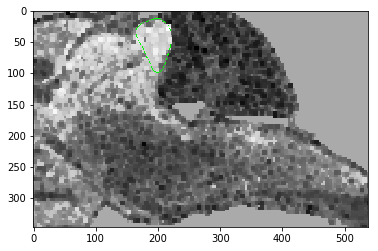

In [55]:
# figure(figsize=[8,8])
com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 30, lineType=8)
imshow(com[::32,::32])
cv2.imwrite(os.environ['ROOT_DIR']+filename, com[::32,::32])

In [56]:
len(grid_features.keys())

15354